# Ladezustand und Batteriespannung
### Eine weitere Beispielanwendung von Regressionsverfahren
<img src="LadezustandBatteriespannung.png">

In [1]:
import pandas as pd
#Daten aus: 
df = pd.read_csv("./batterieladezustand.csv")

In [2]:
df

,Batteriespannung,Ladezustand_Prozent
0,12.7,100
1,12.6,90
2,12.5,80
3,12.4,70
4,12.3,60
5,12.2,50
6,12.1,40
7,11.8,20
8,11.5,10
9,10.5,0


Text(0.5, 0, 'Batteriespannung [V]')

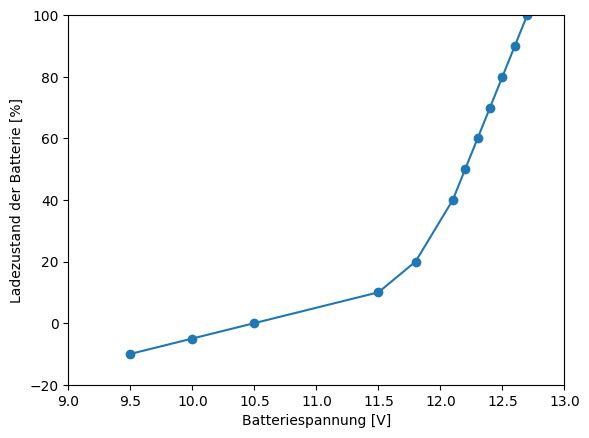

In [3]:
import matplotlib.pyplot as plt
plt.ylim(-20, 100)
plt.xlim(9,13)
plt.plot(df[["Batteriespannung"]], df[["Ladezustand_Prozent"]])
plt.scatter(df[["Batteriespannung"]], df[["Ladezustand_Prozent"]])
plt.ylabel("Ladezustand der Batterie [%]")
plt.xlabel("Batteriespannung [V]")
# Es müssen noch ein paar negativ-Prozentwerte ergänzt werden, sonst funktioniert die Regression nicht so gut

### ...dieses Problem kann polynomal gelöst werden:

In [25]:
X = df[["Batteriespannung"]].values
y = df[["Ladezustand_Prozent"]].values

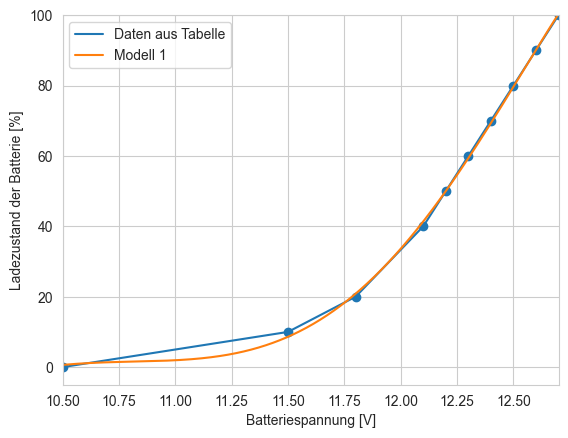

In [26]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 5, include_bias = False)
#include_bias = False  - Wenn das auf True ist, dann gibt es eine zusätzliche Spalte mit einer 1, um den Intercept zu trainieren, falls diser nicht vorhanden wäre.
pf.fit(X) #wäre hier strenggenommen nicht nötig, aber andere Prozesse verlangen das später
pf.transform(X)
X_transformed = pf.transform(X)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_transformed, y)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#sns.set_style("whitegrid", {"axes.facecolor": "#00000000", "figure.facecolor": "#00000000"})
sns.set_style("whitegrid", {})
#sns.set_context("notebook", font_scale=1)
plt.ylabel("Ladezustand der Batterie [%]")
plt.xlabel("Batteriespannung [V]")
plt.ylim(-5, 100)
plt.xlim(10.5,12.7)
plt.plot(X, y, label='Daten aus Tabelle')
plt.scatter(X, y)


values_x = [[x] for x in np.linspace(10,13, 1000)]
model_x = pf.transform(values_x)
#values_x = np.linspace(10,13, 1000) #...oder so
#model_x = [[x, x**2, x**3, x**4, x**5 ] for x in values_x] #...oder so

plt.plot(values_x, model.predict(  model_x ), label='Modell 1' )
plt.legend(loc='upper left')

...sieht aus wie die Simulation einer e-Funktion

In [8]:
#der Bauplan für das Polynom ist:
pf.powers_
#abrufbar. Dort sind die Potenzen der 5 Spalten sichtbar. 

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [9]:
model.coef_

array([[-2.62383659e+05,  4.78502723e+04, -4.34515883e+03,
         1.96429579e+02, -3.53551643e+00]])

In [10]:
model.intercept_

array([573218.64463156])

In [11]:
# Wie gut ist das Modell - Aber Vorsicht, das könnte Overfitting sein, da wir mit den Trainingsdaten evaluieren.
model.score(X_transformed, y)

0.9996194981623743

### Formel:

$$ Ladezustand\text{[%]} = -2.62383659\mathrm{e}{+05} \cdot U \\ + 4.78502723\mathrm{e}{+04} \cdot U^{2}  \\ - 4.34515883\mathrm{e}{+03} \cdot U^{3} \\ + 1.96429579\mathrm{e}{+02} \cdot U^{4} \\- 3.53551643 \cdot U^{5} \\ + 573218.6446676$$ 

...wirkt ziemlich unnatürlich, aufwändig und der Graf sieht aus wie die Simulation einer e-Funktion

## Weitere Idee: Einfachere Formel mit einer e-Funktion

In [12]:
X = df[["Batteriespannung"]]
y = df[["Ladezustand_Prozent"]]
y = y[0:10]
X = X[0:10]
# Das was bei Polynomen die PolynomialFeatures erzeugen, machen wir für die e-Funktion selbst:
import math
X_transformed = [[x, math.exp(x)] for x in X.values.flatten()]

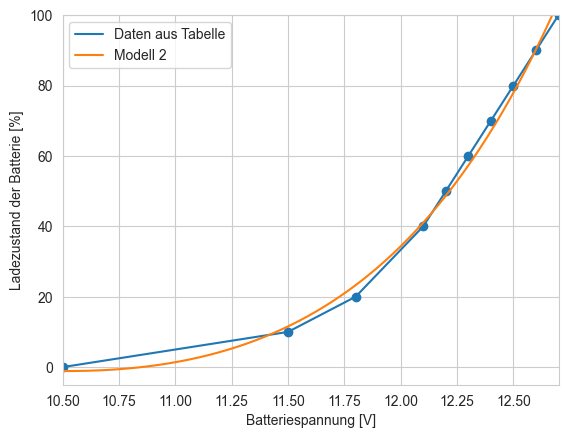

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_transformed, y)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid", {})
plt.ylabel("Ladezustand der Batterie [%]")
plt.xlabel("Batteriespannung [V]")
plt.ylim(-5, 100)
plt.xlim(10.5,12.7)
plt.plot(X, y, label='Daten aus Tabelle')
plt.scatter(X, y)

values_x = np.linspace(10.5,12.7, 1000)
model_x = [[x, math.exp(x)] for x in values_x]
plt.plot(values_x, model.predict(  model_x ), label='Modell 2')
plt.legend(loc='upper left')


In [14]:
# Wie gut ist das Modell??? -  Aber Vorsicht, das könnte Overfitting sein, da wir mit den Trainingsdaten evaluieren.
model.score(X_transformed, y.values)

0.9949086448820192

In [15]:
U = 12.5 #...sollte ca. 80% ergeben:
ex_U = math.e ** U
model.predict([[U, ex_U] ])

array([[77.95621442]])

In [16]:
print('x-Koeffizient, e hoch x - Koeffizient:', model.coef_)
print('Achsenabschnitt: ', model.intercept_)

x-Koeffizient, e hoch x - Koeffizient: [[-1.86049197e+01  5.01145418e-04]]
Achsenabschnitt:  [176.0417094]


In [17]:
x = 12.5
ladezustand = 176.0417094 - (1.86049197e+01 * x) + (5.01145418e-04 * (math.e ** x) )
ladezustand

77.9562147684893

In [18]:
U = 12.5
ladezustand = 176 - (18.6 * U) + (0.000501 * (math.e ** U) )
ladezustand

77.93698054695801

### Formel:

$$ Ladezustand\text{[%]} = 176 - 18.6 \cdot U + 0.000501 \cdot e^{U}$$

...diese Formel erreicht zwar nicht ganz den R-Wert des obigen Polynoms 5. Grades, aber in Anbetracht des physikalischen Hintergrunds ist diese Formel realistisch